In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
%matplotlib inline 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-games-ab-testing/cookie_cats.csv


# Load and Explore the Dataset

In [2]:
df = pd.read_csv("/kaggle/input/mobile-games-ab-testing/cookie_cats.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df['sum_gamerounds'].min(),df['sum_gamerounds'].max()

(0, 49854)

In [5]:
df['sum_gamerounds'].median()

16.0

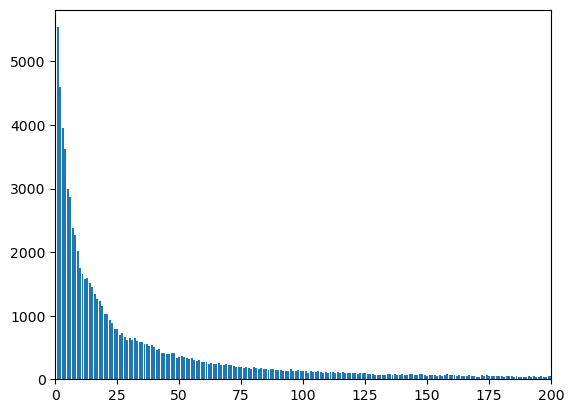

In [6]:
count_gamerounds = df.groupby('sum_gamerounds').size()
plt.bar(x=count_gamerounds.index,
       height=count_gamerounds.values)
plt.xlim(0,200)
plt.show()

In [7]:
df['version'].unique()

array(['gate_30', 'gate_40'], dtype=object)

In [8]:
df[df.duplicated()] #no duplicated enteries available

,userid,version,sum_gamerounds,retention_1,retention_7


In [9]:
df['userid'].nunique()

90189

In [10]:
df['sum_gamerounds'] = df['sum_gamerounds'].astype('int32') #downcasting datatype for preformance
df['version'] = df['version'].astype('category') #changing to category 
df2 = df.set_index('userid')

In [11]:
df2.info() # memory usage went from 2.2mb to 1.3mb

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90189 entries, 116 to 9999861
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   version         90189 non-null  category
 1   sum_gamerounds  90189 non-null  int32   
 2   retention_1     90189 non-null  bool    
 3   retention_7     90189 non-null  bool    
dtypes: bool(2), category(1), int32(1)
memory usage: 1.3 MB


# A/B Testing Retention 1 day

$$H_0: \mu_{gate30} - \mu_{gate40} = 0$$

$$H_1: \mu_{gate30} - \mu_{gate40} \neq 0$$


In [12]:
df2.query("version == 'gate_30'")['retention_1'].mean(),df2.query("version == 'gate_40'")['retention_1'].mean() 

(0.4481879194630872, 0.44228274967574577)

In [13]:
df2.query("version == 'gate_30'")['retention_1'].mean()-df2.query("version == 'gate_40'")['retention_1'].mean() 

0.005905169787341458

In [14]:
n_gate_30 = df2.query("version == 'gate_30'")['version'].count()
n_gate_40 = df2.query("version == 'gate_40'")['version'].count()

In [15]:
n_gate_30, n_gate_40

(44700, 45489)

In [16]:
# calculate obs diff
gate_30_ret = df2.query("version == 'gate_30'")['retention_1']
gate_40_ret = df2.query("version == 'gate_40'")['retention_1']
obs_diff = gate_30_ret.mean() - gate_40_ret.mean()
obs_diff

0.005905169787341458

In [17]:
p_diffs = []
size = df2.shape[0]
for _ in range(10_000):
    sample_df = df2.sample(size, replace=True)
    p_gate_30 = sample_df.query("version == 'gate_30'")['retention_1'].mean()
    p_gate_40 = sample_df.query("version == 'gate_40'")['retention_1'].mean()
    p_diffs.append(p_gate_30-p_gate_40)

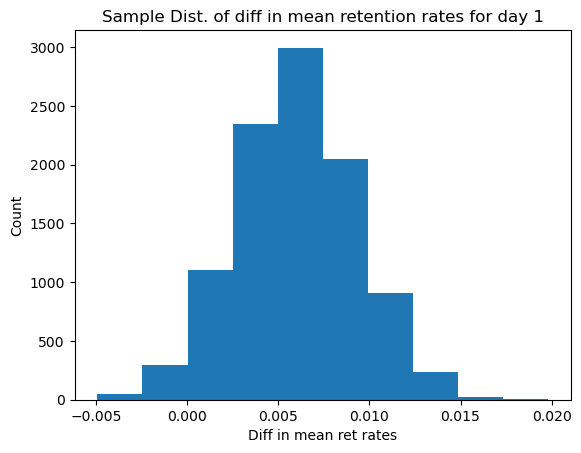

In [18]:
plt.hist(p_diffs)
plt.title("Sample Dist. of diff in mean retention rates for day 1")
plt.xlabel("Diff in mean ret rates")
plt.ylabel("Count")
plt.show()

In [19]:
null_vals = np.random.normal(0,np.array(p_diffs).std(),len(p_diffs))

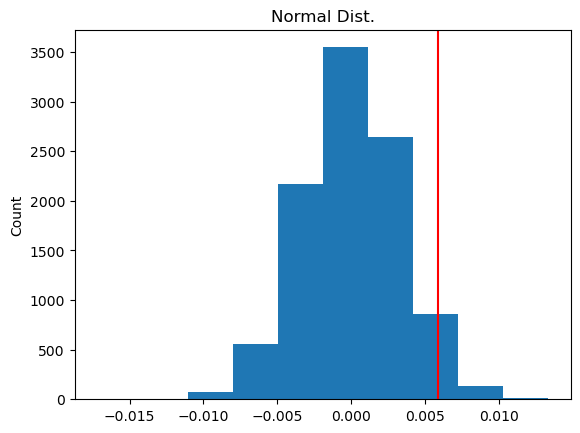

In [20]:
plt.hist(null_vals)
plt.title("Normal Dist.")
plt.ylabel("Count")
plt.axvline(x=obs_diff, color="r")
plt.show()

In [21]:
(null_vals>obs_diff).mean()

0.0339

We reject $H_0$ and we are 95% confident that the gate_40 version's retention rate is significantly different than gate_30 version's retention rate.